In [1]:
%pylab inline
from ipywidgets import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
s0=matrix([[1,0],[0,1]])
s1=matrix([[0,1],[1,0]])
s2=matrix([[0,-1j],[1j,0]])
s3=matrix([[1,0],[0,-1]])
z2=zeros_like(s0);

In [3]:
def h(kx,ky,mz,mm,phi):
    a1=array([0.5,sqrt(3)/2])
    a2=array([-0.5,sqrt(3)/2])
    k=array([kx,ky])
    w1=exp(1j*dot(a1,k))
    w2=exp(1j*dot(a2,k))
    U=kron((s1+1j*s2)/2,s0+1.j*(mz*s3+mm*cos(phi)*s1+mm*sin(phi)*s2))
    U=U+U.H
    T1=kron((s1+1j*s2)/2,s0+1.j*(mz*s3+mm*cos(phi+2/3*pi)*s1+mm*sin(phi+2/3*pi)*s2))
    T2=kron((s1+1j*s2)/2,s0+1.j*(mz*s3+mm*cos(phi-2/3*pi)*s1+mm*sin(phi-2/3*pi)*s2))
    
    return U+w1*T1+w2*T2+(w1*T1+w2*T2).H

In [4]:
yrange=linspace(-2.1*sqrt(3),0,90)
xrange=linspace(0,2*pi,180)
krange=array([append(0*yrange,xrange),append(yrange,0*xrange)]).T
kspace=linspace(0,len(xrange)+len(yrange),len(xrange)+len(yrange));
dk=.8
kX,kY=meshgrid(linspace(4*pi/3-dk,4*pi/3+dk,50),linspace(-dk,dk,50))
SX=kron(s0,s1)
SY=kron(s0,s2)
SZ=kron(s0,s3)

In [9]:
def play(mz=0,mm=0,phi=0,en=0.3):
    dat=[]
    for x,y in krange:
        dat.append(eigvalsh(h(x,y,mz,mm,phi)))        
    plot(kspace,dat,'k-',lw=3);
    plot(kspace,en*kspace**0,'k--',lw=3);
    ylim(-3.5,3.5)
    ylabel(r'$E/\gamma_0$',fontsize=20)
    xlim(0,len(xrange)+len(yrange))
    xticks([0,len(yrange),2/3*len(xrange)+len(yrange),len(xrange)+len(yrange)],
           [r'$M$',r'$\Gamma$',r'$K$',r'$M$'],fontsize=20)
    grid()

def playcont(mz=0,mm=0,phi=0,en=0.3):
    dat2d=[]
    for x,y in array([kX.flatten(),kY.flatten()]).T :
        dat2d.append(eigvalsh(h(x,y,mz,mm,phi)))
    c=[contour(kX,kY,reshape(array(dat2d)[:,2],kX.shape),[en],linewidths=[3],colors='k'),
       contour(kX,kY,reshape(array(dat2d)[:,3],kX.shape),[en],linewidths=[3],colors='k')]
    for i in range(len(c)):
        for kx,ky in c[i].allsegs[0][0][::5]:
            w,v=eigh(h(kx,ky,mz,mm,phi))
            vecx=real((v[:,2].H*SX*v[:,2])[0,0])/3
            vecy=real((v[:,2].H*SY*v[:,2])[0,0])/3  
            arrow(kx,ky,vecx,vecy,color='blue')
    plot(4*pi/3,0,'ko',ms=15)
    text(4*pi/3+0.1,0,r'$K$',fontsize=20)
    xticks([])
    yticks([])
    ylabel(r'$k_y$',fontsize=20)
    xlabel(r'$k_x$',fontsize=20);


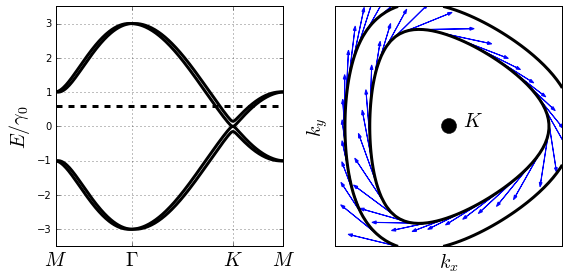

In [10]:
figsize(8,4)
@interact(mz=(0,.14,0.01),mm=(0,.14,0.01),phi=(0,2*pi,0.01*pi),en=(0,3,0.1))
def abragyar(mz=0,mm=0,phi=0,en=0.3):
    subplot(1,2,1)
    play(mz,mm,phi,en)
    subplot(1,2,2)
    playcont(mz,mm,phi,en)
    tight_layout()